# Trabjo Práctico Integrador: Grupo 8
## Integrantes:

- Choconi Lucas
- Berra Eliel
- Mina Federico
- Scillato German

<a id="section_toc"></a> 
## INDICE

[Importaciones de librerías](#section_Import)

[Configuración de gráficos](#section_config)

[Flujo de construcción del Modelo Predictor](#section_logica)

[Análisis y Limpieza de datos](#section_limpieza)

[Feature Selection](#section_feature)

[Pre-Procesamiento](#section_prepros)

$\hspace{.5cm}$[Cambio de Base](#section_cambio)

$\hspace{.5cm}$[Aplicacion SVD](#section_cambio_svd)

[Modelos](#section_modelos)

$\hspace{.5cm}$[Naive Bayes](#section_naive)

$\hspace{.5cm}$[Regresión Logística](#section_rl)

$\hspace{.8cm}$[Regresión Logística Truncando palabras](#section_rl_trun)

$\hspace{.5cm}$[Decision Tree Classifier](#section_tree)

$\hspace{.5cm}$[Boosting de Árboles](#section_boost)

[Evaluación de Modelos - ROC curve](#section_eval)

[Pipeline](#section_pipe)

[Exportación del Modelo Entrenado](#section_pickle)

[Web App](#section_webapp)

<a id="section_Import"></a>  
## Importaciones de librerías

In [21]:
import time

import re

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns

import requests

from nltk.tokenize import word_tokenize
from nltk import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier
from sklearn import tree
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import classification_report, confusion_matrix

from PIL import Image

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from tqdm import tqdm

from xgboost import XGBClassifier

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup

import pickle

from joblib import parallel_backend

import warnings
warnings.filterwarnings('ignore')

<a id="section_config"></a>  
## Configuración de gráficos

In [22]:
# Configuración Graficos 
myColors = ((0.90, 0.96, 1, 1), (0.70, 0.87, 1, 1), (0, 0.40, 0.75, 0.88))
cmap = LinearSegmentedColormap.from_list('Custom', myColors,10)

# Fuente de titulos de gráficos
font = {'color':  'darkred', 'weight': 'normal', 'size': 16}

<a id="section_logica"></a>  

## Flujo de construcción del Modelo Predictor

![Diagrama](./data/fake_d.png)

<a id="section_limpieza"></a>

## Limpieza de datos  y Analisis Exploratorio del Dataset
Importación y limpieza del 
[Dataset](https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset)

In [23]:
# El dataset vino separado en las noticias Falsas y Verdaderas, así que se lo unifica con append 
# entre los archivos True.csv y Fake.csv

file_names_true = pd.read_csv('./data/True.csv')
file_names_true['real'] = 'True'
file_names_fake = pd.read_csv('./data/Fake.csv')
file_names_fake['real'] = 'Fake'
data = file_names_fake.append(file_names_true, ignore_index=True)
data.head(2)

,title,text,subject,date,real
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",Fake
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",Fake


In [24]:
print(f'El dataset tiene un tamaño de {data.shape[0]} registros')

El dataset tiene un tamaño de 44898 registros


In [25]:
# Algunas filas contienen datos erróneos que impiden transformar la columna 'date' a formato fecha
wrong_row = data['date'] == 'https://100percentfedup.com/served-roy-moore-vietnamletter-veteran-sets-record-straight-honorable-decent-respectable-patriotic-commander-soldier/'
data[wrong_row]

,title,text,subject,date,real
9358,https://100percentfedup.com/served-roy-moore-v...,https://100percentfedup.com/served-roy-moore-v...,politics,https://100percentfedup.com/served-roy-moore-v...,Fake


In [26]:
# Las filas que no pueden ser correctamente transformadas a datetime
# serán utilizadas en una máscara booleana para poder eliminarlas

data['date'] = data['date'].apply(lambda x: pd.to_datetime(x,
                                                    infer_datetime_format = True)\
                                                    if re.search('[a-z-A-Z]+ [0-9]+, [0-9]{4}', x) else  np.NaN)
delete_mask = data['date'].notna()
data = data[delete_mask]
data = data.reset_index()
data['date'] = data['date'].astype('datetime64')

Text(0.5, 1.0, 'Categoría de las Noticias')

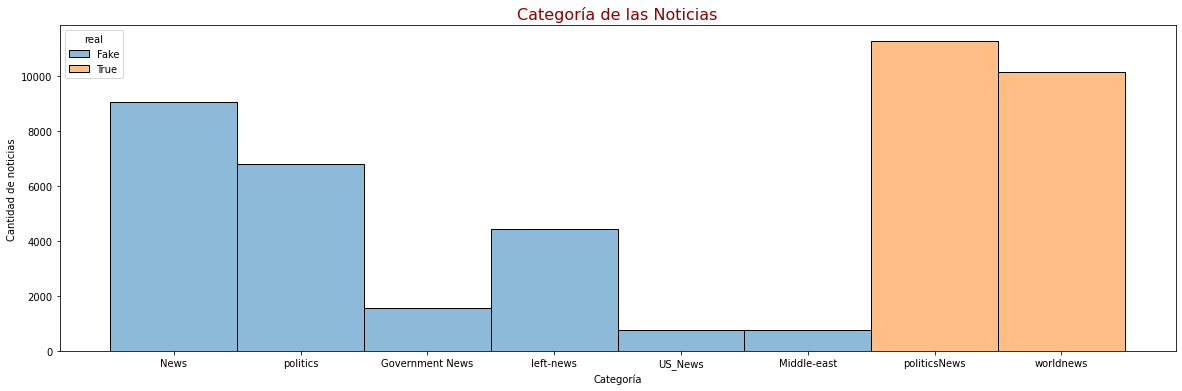

In [27]:

plt.figure(figsize=(20,6))
ax =sns.histplot(data = data, x = 'subject', hue = 'real'  )
plt.ylabel('Cantidad de noticias')
plt.xlabel('Categoría')
plt.title("Categoría de las Noticias", fontdict= font)


In [28]:
# Como hay valores diferentes en la columna "subject" para las noticias reales y las falsas borramos esa columna
data = data.drop(columns = 'subject')

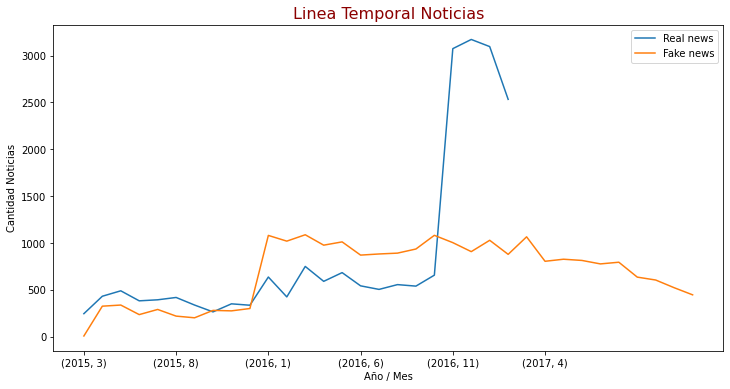

In [29]:
# Separamos los datos en dos máscaras con las filas que contienen noticias falsas de las que son reales
mask_real = data['real'] == 'True'
mask_fake = data['real'] == 'Fake'

data_real = data[mask_real]
data_fake = data[mask_fake]

# Hacemos un gráfico mostrando el conteo de cuántas noticias falsas y cuántas verdaderas se publicaron 
# por mes en el dataset 
plt.figure(figsize=(12,6))
ax = data_real['date'].groupby([data_real["date"].dt.year,
                             data_real["date"].dt.month]).count().plot.line(label = 'Real news')

ax = data_fake['date'].groupby([data_fake["date"].dt.year,
                            data_fake["date"].dt.month]).count().plot.line(label = 'Fake news')
ax.set(xlabel=None)
ax.set_title('Linea Temporal Noticias' , fontdict = font)
ax.set_xlabel('Año / Mes')
ax.set_ylabel('Cantidad Noticias')
ax.legend()

El pico de noticias verdaderas publicadas en Noviembre del 2016 coincide con las elecciones presidenciales de Estados Unidos

Text(0.5, 0, 'Noticias Falsas y Verdades')

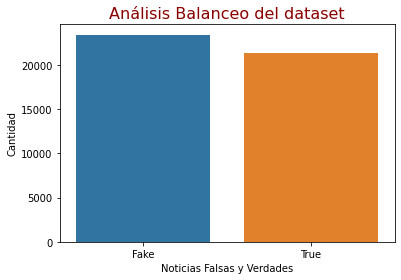

In [30]:
# Se observa que el dataset está muy balanceado. Cuando se evalúe el accuracy de un modelo deberá
# compararse contra el %50 de la estratificación de la variable target.

ax = sns.countplot(data['real'])
ax.set_title('Análisis Balanceo del dataset', fontdict = font)
ax.set_ylabel("Cantidad")
ax.set_xlabel("Noticias Falsas y Verdades")



100%|██████████| 542/542 [00:00<00:00, 738.76it/s]


Text(0.5, 1.0, 'Promedio de cantidad de palabras por noticia')

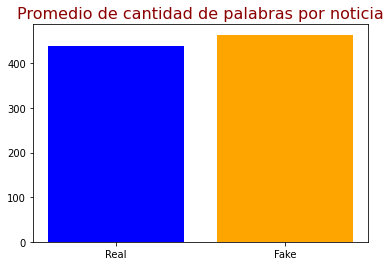

In [31]:
# Las dos siguientes operaciones suelen demorar mucho en ejecutarse, por eso se va a trabajar con un sampleo
# de los datos, intentando aumentar la velocidad y que su ejecución se más práctica. Si no se trabaja
# con el sampleo, la función que se encuentra más abajo que obtiene el porcentaje de palabras del artículo
# que están en el diccionario se demoraría 40hs, con el sampleo se reduce a 1 hora.

data_sample = data.sample(1000)
mask_real = data_sample['real'] == 'True'
mask_fake = data_sample['real'] == 'Fake'
data_real_sample = data_sample[mask_real]
data_fake_sample = data_sample[mask_fake]

# Averiguamos cuál es el largo promedio de las noticias falsas y de las reales

tqdm.pandas()                        
data_real_sample['text_len'] = data_real_sample['text'].progress_apply(lambda x: len(word_tokenize(x)))
data_fake_sample['text_len'] = data_fake_sample['text'].progress_apply(lambda x: len(word_tokenize(x)))

# Gráfico comparativo del largo promedio de las noticias falsas y verdaderas
real_len_avg = data_real_sample['text_len'].mean()
fake_len_avg = data_fake_sample['text_len'].mean()
len_avgs = [real_len_avg, fake_len_avg]
plt.bar(['Real', 'Fake'], len_avgs, color = ['blue', 'orange'])
plt.title('Promedio de cantidad de palabras por noticia' , fontdict= font)

In [32]:
'''
# Lista con todas las palabras en inglés https://github.com/dwyl/english-words/blob/master/words.txt
all_eng_words = pd.read_csv('./data/all_english_words.csv')
all_eng_words = pd.Series(all_eng_words.iloc[:,0])
all_eng_words = all_eng_words.apply(lambda x: x.lower() if type(x) == str else x)

def words_percentage(text):
    #Devuelve el porcentaje de palabras que posee un texto que están dentro de un diccionario
    words = word_tokenize(text)
    words = [re.sub('[^A-Za-z0-9]+', '', word) for word in words] 
    words_in_dict = [word for word in words if word in all_eng_words.values]
    try: 
        words_in_dict_percentage = len(words_in_dict) * 100 / len(words)
    except ZeroDivisionError:
        return 0
    return words_in_dict_percentage

data_sample['words_in_dict_pct'] = data_sample['text'].progress_apply(words_percentage)

data_sample_pct_location = './data/data_with_pct.csv'
data_sample.to_csv(data_sample_pct_location, index = False)
'''
''' Esta celda demora apróximadamente 50 minutos en ejecutarse. Se puede obtener el dataset con los resultados
de esta operación ejecutando la celda de abajo.'''

' Esta celda demora apróximadamente 50 minutos en ejecutarse. Se puede obtener el dataset con los resultados\nde esta operación ejecutando la celda de abajo.'

Text(0.5, 1.0, 'Porcentaje Promedio  de palabras por noticia presentes en diccionario')

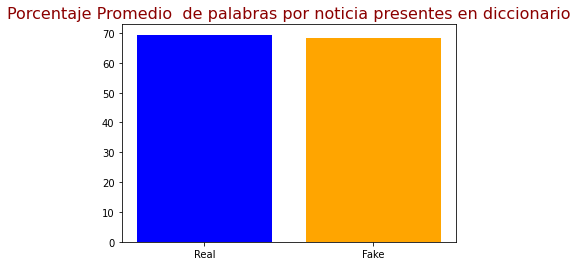

In [33]:
# Levantamos el dataset de la celda de arriba
data_sample_pct_location = './data/data_with_pct.csv'
data_sample = pd.read_csv(data_sample_pct_location)
mask_real = data_sample['real'] == 'True'
mask_fake = data_sample['real'] == 'Fake'
data_real_sample = data_sample[mask_real]
data_fake_sample = data_sample[mask_fake]

# El objetivo es identificar si las noticias verdaderas utilizan más palabras reconocidas por el diccionario
# que las noticias falsas, que probablemente utilicen más el lenguaje conocido como "slang"
# Para verificar eso se realiza el siguiente gráfico
real_words_dict_pct = data_real_sample['words_in_dict_pct'].mean()
fake_words_dict_pct = data_fake_sample['words_in_dict_pct'].mean()
words_dict_pcts = [real_words_dict_pct, fake_words_dict_pct]
plt.bar(['Real', 'Fake'], words_dict_pcts, color = ['blue', 'orange'])
plt.title('Porcentaje Promedio  de palabras por noticia presentes en diccionario' , fontdict= font)

Nuestra hipótesis de que las noticias verdaderas iban a contenter un promedio del porcentaje de palabras contenidas en el diccionario no era correcta, es un poco mayor pero la diferencia es despreciable

In [34]:
# Función para graficar las manos con pulgar hacia arriba/abajo

def blue_color_func(word, font_size, position,orientation, **kwargs):
    """Argumentos de función necesarias para metodo worldcloud"""
    blues = "hsl(215,100%%, %d%%)" % np.random.choice(np.arange(25, 65, 5, dtype=int))
    reds = "hsl(0,100%%, %d%%)" % np.random.choice(np.arange(40, 80, 5, dtype=int))
    choice = np.random.choice([0, 1])
    if choice == 0:
        return blues
    else:
        return reds

def graficos_manos(fake,true):
    """Función para graficar worldcloud en forma de manos,
    falsas y verdaderas. Variables: worldcloud falsa y verdadera"""
    fig, axs = plt.subplots(1, 2,figsize=(20,10))  

    axs[1].imshow(fake.recolor(color_func=blue_color_func, random_state=3),
                interpolation="bilinear")
    axs[1].axis("off")
    axs[1].set_title('FAKE' , fontdict = font)
    axs[0].imshow(true.recolor(color_func=blue_color_func,random_state=3),
                interpolation="bilinear")
    axs[0].axis("off")
    axs[0].set_title('TRUE' , fontdict = font)
    plt.show()
    
# Importación de imagenes para graficos de manos.

mask_pos = np.array(Image.open("./data/Thumbs.png"))
mask_neg = np.array(Image.open("./data/Thumbsdw.png"))

In [35]:
# Generamos un gráfico que muestra visualmente las palabras que más frecuentemente aparecen tanto en noticias
# falsas como verdaderas

stopwords_en = stopwords.words('english')

wordcloud_fake = WordCloud(stopwords=stopwords_en,
            mask=mask_neg, 
            max_words=500,
            background_color="white").generate(data_real.text.str.cat(sep=' '))
wordcloud_true = WordCloud(stopwords=stopwords_en,
            mask=mask_pos,
            max_words=500,
            background_color="white").generate(data_fake.text.str.cat(sep=' '))

graficos_manos(fake = wordcloud_fake,true = wordcloud_true)

Se verifica que el dataset no posea NaNs

In [ ]:
# El dataset no valores nulos así que damos por finalizada la limpieza y el Análisis Exploratorio Inicial
print(data.isna().sum())

<a id="section_sinstop"></a>  
## Feature Selection 

### Removiendo stopwords que overfittean el modelo
En esta sección se analiza el sobreajuste para el dataset inicial, evauando las palabras que están overfiteando el modelo, es decir, aquellas que de forma arbitraria elevan el score del modelo pero que hace que pierda capacidad predicitiva generalizada. Para ello se utiliza un modelo de ábroles y a través de la propiedad de feature importance se observa el puntaje de las palabras que poseen un coeficiente muy elevado.

Se consideran los siguientes puntos para esta sección
- Se utiliza un modelo simple de tree, con tendencia a sobreajuste.
- En las secciones siguientes se vuelve a definir los X_train, X_test, y_train e y_test.

In [ ]:
# Se va a utilizar el dataset completo para evaluar todas las stopwords posibles que estén sobre ajustando
# el modelo
X = data['text']
y = data['real']
X_train_completo, X_test_completo, y_train_completo, y_test_completo = train_test_split(X, y, test_size = 0.3)

In [ ]:
# Definición de función para el tokenizer
def porter_tokenizer(text):
    ''' Esta función se utiliza cuando se sobre escribe el proceso
    de tokenización en la clase CountVectorizer para que se pueda
     obtener también la raíz de la palabra con el método Porter.'''
    porter = PorterStemmer()
    # Tener en cuenta que está utilizando la variable global stopwords_en
    stopwords_en_porter = [porter.stem(x) for x in stopwords_en]
    words = word_tokenize(text)
    words = [re.sub('[^A-Za-z0-9]+', '', word) for word in words]  # remover los caracteres especiales
    words = [word.replace(' ', '') for word in words] #remover los espacios en blanco
    words = [word for word in words if word != '']
    words = [porter.stem(word) for word in words] # obtener la raiz de las palabras
    words = [word for word in words if word not in stopwords_en_porter] # remover las stopwords
    return words

In [ ]:
# Definición de función para el tokenizer con Lancaster Stemmer que será utilizado en el pipeline
def lancaster_tokenizer(text):
    ''' Esta función se utiliza cuando se sobre escribe el proceso
    de tokenización en la clase CountVectorizer para que se pueda
     obtener también la raíz de la palabra con el ḿetodo Lancaster.'''
    lancaster = LancasterStemmer()
    # Tener en cuenta que está utilizando la variable global stopwords_en
    stopwords_en_lancaster = [lancaster.stem(x) for x in stopwords_en]
    words = word_tokenize(text)
    words = [re.sub('[^A-Za-z0-9]+', '', word) for word in words]  # remover los caracteres especiales
    words = [word.replace(' ', '') for word in words] #remover los espacios en blanco
    words = [word for word in words if word != '']
    words = [lancaster.stem(word) for word in words] # obtener la raiz de las palabras
    words = [word for word in words if word not in stopwords_en_lancaster] # remover las stopwords
    return words

In [ ]:
# Se define stopwords y se genera nuevamente la vectorización, y la matriz tfidf

customized_vectorizer_feature= CountVectorizer(lowercase = True,
                                               strip_accents='unicode', 
                                               tokenizer = porter_tokenizer,
                                               ngram_range = (1, 3),
                                               min_df = 3)

customized_vectorizer_matrix = customized_vectorizer_feature.fit_transform(X_train_completo)
customized_vectorizer_test = customized_vectorizer_feature.transform(X_test_completo)

In [ ]:
tfidf_matrix_train_completo = TfidfTransformer().fit_transform(customized_vectorizer_matrix)
tfidf_matrix_test_completo = TfidfTransformer().fit_transform(customized_vectorizer_test) 

X_train_completo= tfidf_matrix_train_completo
X_test_completo = tfidf_matrix_test_completo

In [ ]:
# Modelo ejemplo para mostrar sobre ajuste.
my_tree = tree.DecisionTreeClassifier(criterion='entropy', max_depth=5)
my_tree.fit(X_train_completo , y_train_completo )
print("Score modelo con stopwords sin retirar: {} %".format(my_tree.score(X_test_completo ,
                                            y_test_completo )*100))

Se observa un accuracy muy elevado, cercano al 1, lo que indica un claro sobre ajuste. Si se quiere comparar el score entre este árbol overfitteado y un árbol sin las palabras que sobreajustan el modelo ir a la sección [Decision Tree Classifier](#section_tree).

In [ ]:
# Se evalúa el  peso de cada palabra.
importancia_features = pd.DataFrame(my_tree.feature_importances_,
                                 index = customized_vectorizer_feature.get_feature_names(),
                                 columns=['importancia'])
importancia_features_sort = importancia_features.sort_values('importancia', ascending=False)
print(importancia_features_sort[0:10])

En la celda de arriba se observa que la palabra "reuter" está overfiteando el modelo, ya que muchas de las noticias verdaderas contienen la palabra "Reuters" en su contenido, siendo este el medio que las emite. 
Por eso se la va a añadir como stopword. Este procedimiento se iteró forma manual y repetida, identificando en cada corrida de cada modelo cuáles eran las palabras que overfiteaban el modelo, para luego añadirlas al listado de stopwords para agregar que figura en la celda de abajo. No se agregan todas las pruebas realizadas para no llenar de código innecesario la notebook, pero se deja constancia y explicación del procedimiento realizado.

In [ ]:
# Agregado de Stopwords específicas del dataset que overfittean el modelo.

def append_stopword(listado_stopwords, stopwords_agregar):
    for stopwords in stopwords_agregar:
        listado_stopwords.append(stopwords)
    return listado_stopwords

stopwords_agregar = ['reuter','said','Reuters','via','imag','https','com','one',
'u','also','would','featur','pic','us','wednesday','friday','monday','tuesday',
'saturday','sunday','thursday','getti','read','gop','watch','donald','trump',
'hillari','mr','accord','america','seem','youtub','21st',
'video' , 'http' , 'like' , 'obama' , 'minist' , 'washington' , 'know' , 'wwwyoutubecomwatch' ]


porter = PorterStemmer()
stopwords_en_porter = [porter.stem(x) for x in stopwords_en]
stopwords_en = append_stopword(stopwords_en_porter ,stopwords_agregar )

<a id="section_prepros"></a>  

## Pre-procesamiento

Se divide el dataset en train y test. 

In [ ]:
# Algunas operaciones se demoran mucho tiempo debido a la gran cantidad de columnas que se generan al vectorizar
# los datos, el tamaño pequeño de la muestra es para agilizar las operaciones. De todas maneras, el tamaño
# de la muestra es lo suficientemente significativo como obtener un buen accuracy.
sample_size = 1000 
testing_sample_size = 50 # Para hacer testeos aún más rápidos se recomienda este sampleo 
data_sample = data.sample(sample_size)
X = data_sample['text']
y = data_sample['real']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [ ]:
# La ventaja de este CountVectorizer es que incluye una función porter_tokenizer como parámetro que permite
# customizar el procedimiento para obtener la raíz de la palabra
customized_vectorizer= CountVectorizer(lowercase = True,
                                       strip_accents='unicode', 
                                       tokenizer = porter_tokenizer,
                                       ngram_range = (1, 3),
                                       min_df = 3)

customized_vectorizer_train = customized_vectorizer.fit_transform(X_train)
customized_vectorizer_test = customized_vectorizer.transform(X_test)

In [ ]:
# Construcción de matrices tfidf
tfidf_matrix_train = TfidfTransformer().fit_transform(customized_vectorizer_train)
tfidf_matrix_test = TfidfTransformer().fit_transform(customized_vectorizer_test) 

<a id="section_cambio"></a>  
### Cambio de Base

Evaluación del impacto con distintas cantidades de componentes

In [ ]:
def select_n_components(var_ratio, goal_var, should_graph = True): 
    ''' Esta función se utiliza para hacer un cambio de base y lograr explicar
    el porcentaje de los datos que se pasa en el argumento goal_var.
    Fuente https://chrisalbon.com/code/machine_learning/feature_engineering/select_best_number_of_components_in_tsvd/
    Fue modificada para que, sí el parámetro should_graph es True,haga un gráfico de la varianza explicativa
    del modelo de acuerdo al número de componentes'''
    # Set initial variance explained so far
    total_variance = 0.0
    # Set initial number of features
    n_components = 0
    # Listas del nuḿero de componentes y de la explicación de varianza alcanzada para poder graficarlas
    num_components = list(range(1, len(var_ratio) + 1))
    variances = []
    # For the explained variance of each feature:
    found_n_components = False
    for explained_variance in var_ratio:
        # Add the explained variance to the total
        total_variance += explained_variance
        # Add one to the number of components
        n_components += 1
        # Agregar la varianza explicada al listado 
        variances.append(total_variance)
        # If we reach our goal level of explained variance and we haven't reached our desired variance
        if total_variance >= goal_var and found_n_components == False:
            desired_n_components = n_components
            found_n_components = True
            desired_variance = total_variance
    
    if should_graph == True:
        plt.plot(num_components, variances )
        plt.scatter(desired_n_components, desired_variance, c = 'r')
        plt.xlabel('Número de componentes')
        plt.ylabel('Razón de la explicación de la varianza')
        plt.hlines(desired_variance, 0, desired_n_components, 'r', 'dashed')
        plt.vlines(desired_n_components, 0, desired_variance, 'r', 'dashed')
        plt.title("Comparativa Varianza vs Número componentes ",fontdict=font)
        
    # Return the desired number of components. 
    return desired_n_components

In [ ]:
# Evaluación de cambio de base para 3 threshold
# Evaluamos cómo responde el cambio de base cuando seleccionamos una explicación
# de la varianza alta (0.9), media (0.5) o baja (0.1)
desired_threshold = [0.9 , 0.5 , 0.1]

# Tener en cuenta que si el número de filas de la matrix esparsa es menor al número de componentes elegido
# como hiperparámetro, una vez que se haya realizado la transformación SVD el número de componentes 
# obtenido será igual al número de filas de la matriz esparsa, y no será el número de componentes
# elegido como hiperpárametro
for thres in desired_threshold:
    test_svd = TruncatedSVD(n_components = tfidf_matrix_train.shape[1] - 1);
    test_svd.fit(tfidf_matrix_train)
    tsvd_var_ratios = test_svd.explained_variance_ratio_
    desired_threshold = thres
    n_components = select_n_components(tsvd_var_ratios, desired_threshold)

    print(f'Para Threshold {thres} número de componentes después del cambio de base: {n_components}')

<a id="section_cambio_svd"></a>  
##### Aplicacion SVD

Se concluye que se tiene una performance aceptable aunque solo se capture el 10% de la varianza del dataset. Por lo cual, en el pipeline se incluiran los 3 threshold.

<a id="section_modelos"></a> 
## Modelos

En esta sección se entrenan y testean distintos modelos.

In [ ]:
# Definición de X train y test a partir de las matrices tfidf
# Se utiliza la matriz esparsa sin transformarla a DataFrame para que los procesos se ejecuten más rápidamente
# No utilizamos el cambio de base con SVD porque suponemos que esa pérdida de información impactará negativamente
# en el accuracy, pero lo incluiremos en el Pipeline para verificarlo.

X_train = tfidf_matrix_train
X_test = tfidf_matrix_test

<a id="section_naive"></a> 
### Naive Bayes

In [ ]:
NB_model = MultinomialNB()
NB_model.fit(X_train, y_train)
NB_model.score(X_test, y_test)

In [ ]:
axis_labels = np.sort(y_test.unique())
cm_nb = confusion_matrix(y_test, NB_model.predict(X_test))
sns.heatmap(cm_nb, xticklabels=axis_labels, yticklabels=axis_labels, cbar=False, annot=True, cmap=cmap, fmt='g')
plt.ylabel('Etiquetas reales'), plt.xlabel('Etiquetas predichas')

<a id="section_rl"></a> 
### Regresión Logistica

In [ ]:
reg_model = LogisticRegression(C = 7, solver="saga", l1_ratio=0.5 ,
                                 penalty="elasticnet", n_jobs=-1)
reg_model.fit(X_train, y_train)
reg_model.score(X_test, y_test)

In [ ]:
cm_rlog = confusion_matrix(y_test, reg_model.predict(X_test))
sns.heatmap(cm_rlog, xticklabels=axis_labels, yticklabels=axis_labels,
             cbar=False, annot=True, cmap=cmap, fmt='g')
plt.ylabel('Etiquetas reales'), plt.xlabel('Etiquetas predichas')

In [ ]:
Coef_reg_model = pd.DataFrame(np.transpose(reg_model.coef_), index=customized_vectorizer.get_feature_names(),
 columns=['Coef'])
Coef_reg_model['coef_abs'] = abs(Coef_reg_model['Coef'])
Coef_reg_model = Coef_reg_model.reset_index(-1)
Coef_reg_model['words'] = Coef_reg_model['index'] 
Coef_reg_model['freq'] = (round(Coef_reg_model['coef_abs'] / Coef_reg_model.coef_abs.sum()* Coef_reg_model.shape[0] * 1000 , 0)).apply(lambda x: int(x))
Coef_reg_model['odds_direction'] = Coef_reg_model['Coef'].apply(lambda x: 'Negative' if x<0 else 'Positive')

Coef_reg_model_positive = Coef_reg_model[Coef_reg_model['odds_direction']=='Positive']
Coef_reg_model_positive = Coef_reg_model_positive.drop(['Coef' ,'coef_abs', 'index', 'odds_direction'], axis=1)
Coef_reg_model_negative = Coef_reg_model[Coef_reg_model['odds_direction']=='Negative']
Coef_reg_model_negative = Coef_reg_model_negative.drop(['Coef' ,'coef_abs', 'index', 'odds_direction'], axis=1)

In [ ]:
tuples_pos = Coef_reg_model_positive.set_index('words').T.to_dict('index')
tuples_neg = Coef_reg_model_negative.set_index('words').T.to_dict('index')

wordcloud_positive = WordCloud(max_words=500, mask=mask_pos,
        background_color="white").generate_from_frequencies(dict(tuples_pos['freq']))
wordcloud_negative = WordCloud(max_words=500, mask=mask_neg,
        background_color="white").generate_from_frequencies(dict(tuples_neg['freq']))

graficos_manos(fake = wordcloud_negative,true = wordcloud_positive)

<a id="section_rl_trun"></a> 
#### Modelo de Reg. Logistica Truncando palabras

In [ ]:
test_svd = TruncatedSVD(n_components = X_train.shape[1] - 1);
test_svd.fit(X_train)
tsvd_var_ratios = test_svd.explained_variance_ratio_
desired_tsh_10, desired_tsh_50, desired_tsh_90 = 0.1, 0.5, 0.9
n_components_90_var = select_n_components(tsvd_var_ratios, desired_tsh_90, should_graph = False)
n_components_50_var = select_n_components(tsvd_var_ratios, desired_tsh_50, should_graph = False)
n_components_10_var = select_n_components(tsvd_var_ratios, desired_tsh_10, should_graph = False)

In [ ]:
svd_90 = TruncatedSVD(n_components = n_components_90_var)
svd_50 = TruncatedSVD(n_components = n_components_50_var)
svd_10 = TruncatedSVD(n_components = n_components_10_var)

X_train_svd_90 = svd_90.fit_transform(X_train)
X_test_svd_90 = svd_90.transform(X_test)
X_train_svd_50 = svd_50.fit_transform(X_train)
X_test_svd_50 = svd_50.transform(X_test)
X_train_svd_10 = svd_10.fit_transform(X_train)
X_test_svd_10 = svd_10.transform(X_test)

In [ ]:
X_svd = [[X_train_svd_90,X_test_svd_90],[X_train_svd_50,X_test_svd_50],[X_train_svd_10,X_test_svd_10]]
scores = []
models = []
for svd in X_svd:
    reg_model_svd = LogisticRegression(C = 8, solver="newton-cg", penalty="l2")
    models.append(reg_model_svd.fit(svd[0], y_train))
    scores.append(reg_model_svd.score(svd[1], y_test))

In [ ]:
figs, axs = plt.subplots(1,3, figsize= (15,5))
title = [90,50,10]
for i in range(3):
    
    cm_rlog_svd = confusion_matrix(y_test, models[i].predict(X_svd[i][1]))
    sns.heatmap(cm_rlog_svd,xticklabels=axis_labels, yticklabels=axis_labels,
                cbar=False, annot=True, cmap=cmap, fmt='d', ax = axs[i],
                linecolor = "w" , linewidths = .5,square=True)
    axs[i].set_title(label = f'Tsh {title[i]} - Accuracy: {scores[i].round(2)} ' , 
    loc ='left', fontdict = font )
    axs[0].set_ylabel('Etiquetas reales')
    axs[i].set_xlabel('Etiquetas predichas')
    plt.suptitle(t='SVD con diferentes Thresholds (Tsh)', fontsize = "x-large" )

<a id="section_tree"></a> 
### Decision Tree Classifier

In [ ]:
my_tree = tree.DecisionTreeClassifier(criterion='gini', max_depth=5)
my_tree.fit(X_train, y_train)
accuracy_tree = my_tree.score(X_test, y_test)
print(accuracy_tree)

In [ ]:
cm_tree = confusion_matrix(y_test, my_tree.predict(X_test))
sns.heatmap(cm_tree, xticklabels=axis_labels, yticklabels=axis_labels,
            cbar=False, annot=True, cmap=cmap, fmt='g')
plt.ylabel('Etiquetas reales'), plt.xlabel('Etiquetas predichas')

In [ ]:
plt.figure(figsize=(20,6))
tree.plot_tree(my_tree,feature_names = customized_vectorizer.get_feature_names(),
                filled=True,rounded=True, fontsize = 10)
plt.show()

<a id="section_boost"></a> 

### Boosting de Árboles

In [ ]:
boost_tree = AdaBoostClassifier(base_estimator = my_tree, 
                            n_estimators = 200,
                            learning_rate = 0.8)

boost_tree.fit(X_train, y_train) 
boost_tree.score(X_test, y_test)

In [ ]:
cm_boost_tree = confusion_matrix(y_test, boost_tree.predict(X_test))
sns.heatmap(cm_boost_tree, xticklabels=axis_labels, yticklabels=axis_labels, cbar=False, annot=True, cmap=cmap, fmt='g')
plt.ylabel('Etiquetas reales'), plt.xlabel('Etiquetas predichas')

In [ ]:
## Comparación del accuracy de los modelos
models = [NB_model, reg_model, my_tree, boost_tree]
model_names = ['Multinomial Bayes', 'Logistic Regression', 'Decision Tree', 'AdaBoost']
scores = [model.score(X_test, y_test) for model in models]

plt.plot(model_names, scores)
plt.title("Comparativa Accuracy Modelos" , fontdict= font)

<a id="section_eval"></a> 

## Evaluación de los modelos - Roc Curve 

In [ ]:


#   Se convierte etiquetas a Int 0 y 1
y_roc = y_test.apply(lambda x: 1 if x == "True" else 0)

In [ ]:
def ROC_curve(models, X_test , y_test):
    "Calcula las probabilidades y grafica la ROC Curve de los modelos en lista 'Modelos'. "
    for i, model in enumerate(models):
        y_pred_proba = model.predict_proba(X_test)
        fpr_log, tpr_log, thr_log = roc_curve(y_roc, y_pred_proba[:,1])
        df = pd.DataFrame(dict(fpr=fpr_log, tpr=tpr_log, thr = thr_log))
        plt.plot(df['fpr'],df['tpr'], label=model_names[i])
        
    plt.legend()
    plt.axis([0, 1.01, 0, 1.01])
    
    plt.xlabel('1 - Specificty'); plt.ylabel('TPR / Sensitivity'); plt.title('ROC Curve')
    plt.plot(np.arange(0,1, step =0.01), np.arange(0,1, step =0.01))
    
    plt.show()

ROC_curve(models = models, X_test = X_test , y_test = y_test)

<a id="section_pipe"></a> 

## Pipeline

In [ ]:
# Las operaciones con grid search suelen tomar mucho tiempo, si se quiere hacer pruebas descomentar y
# ejecutar esta celda para reducir el número de registros
'''
small_testing_sample_size = 20

data_sample = data.sample(small_testing_sample_size)
X = data_sample['text']
y = data_sample['real']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
'''
''''''

In [ ]:
# Se redefinen las variables features y target de entrenamiento y de testeo porque el X_train había sido
# empleado como una Matriz esparsa de TFIDF, y en el pipeline se tienen que introducir los datos
# sin que hayan pasado por el Pre Procesamiento. 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [ ]:
pasos = [('vectorizador', CountVectorizer()),
         ('tfidf', TfidfTransformer()), 
         ('cambio_base', TruncatedSVD()),
         ('classifier', LogisticRegression())]
pipeline = Pipeline(pasos)

In [ ]:
# Clase construida para generar cambios de base con diferente número de componentes en el pipeline
class SVD_n_components(BaseEstimator, TransformerMixin):
    
    def __init__(self, n_components):
        self.n_components = n_components
        
    def fit(self, X, y):
        return self
    
    def transform(self, X, y):
        svd = TruncatedSVD(n_components = self.n_components);
        return svd.fit_transform(X, y)

In [ ]:
# La búsqueda de hiperparámetros en los pasos de pre procesamiento (vectorización, tfidf y cambio de base)
# será común a todos los modelos en el Grid Search.
pre_processing = {
                'vectorizador__lowercase': [True],
                'vectorizador__strip_accents': ['unicode'],   
                'vectorizador__ngram_range': [(1,3)],
                'vectorizador__min_df': [0.001],
                'vectorizador__tokenizer': [porter_tokenizer], 
                # Se elije porter para realizar la tokenización, debido a que las stopwords que sobreajustan fueron agregadas
                # ya habiendose realizado el proceso de stem, y requiere un nuevo análisis de Feature importance para Lancaster
                'cambio_base': [None,SVD_n_components(n_components_50_var)]
                 }

param_grid = [
              {**pre_processing,
               **{'classifier': [LogisticRegression()],
                  'classifier__penalty': ['elasticnet', 'none'],
                  'classifier__C': [ 1, 4, 7]}},              

              {**pre_processing,
               **{'classifier': [MultinomialNB()]}},
              
              {**pre_processing,
               **{'classifier': [AdaBoostClassifier()],
                  'classifier__n_estimators': [25, 50],
                  'classifier__base_estimator': [DecisionTreeClassifier()],
                  'classifier__base_estimator__criterion': ['gini'],
                  'classifier__base_estimator__max_depth': [5],
                  'classifier__base_estimator__max_features': [4000] } } 
                  # Se deja 4000 porque de forma simple no se logro tomar el valor de features vectorizadas.
                  # Usualmente estaba entre 9000 a 10000 features, con 1000 records.
              ]

In [ ]:
n_folds = 5
param_grid_combinations = ParameterGrid(param_grid)
len_param_grid = len(param_grid_combinations)
print(f'La cantidad de combinaciones que debe realizar el GridSearchCV es de {len_param_grid}, multiplicado por {n_folds} que es el número de Folds, se obtiene un total de {len_param_grid * n_folds} posibilidades.')

In [ ]:
# Esta celda demora 70 mins en ejecutarse

with parallel_backend('threading', n_jobs = -1):
    folds=StratifiedKFold(n_splits = n_folds, shuffle = True)
    grid = GridSearchCV(estimator = pipeline,param_grid = param_grid, cv = folds, verbose = 1)
    grid.fit(X_train, y_train)

In [ ]:
grid.best_score_

In [ ]:
grid.best_estimator_

In [ ]:
grid.best_params_

### Grid Search Testing
Se realiza testing final con dataset completo

In [ ]:
y_pred_grid = grid.predict(X_test)
confusion_grid = confusion_matrix(y_test, y_pred_grid)
sns.heatmap(confusion_grid, xticklabels=axis_labels, yticklabels=axis_labels, cbar=False, annot=True, cmap=cmap, fmt='g')
plt.ylabel('Etiquetas reales')
plt.xlabel('Etiquetas predichas')
print (classification_report(y_test, y_pred_grid))
print(f'El modelo obtuvo un accuracy de {accuracy_score(y_pred_grid, y_test)}')

In [ ]:
# Se re
X = data['text']
y = data['real']

In [ ]:
y_pred_grid = grid.predict(X)
confusion_grid = confusion_matrix(y, y_pred_grid)
sns.heatmap(confusion_grid, xticklabels=axis_labels, 
yticklabels=axis_labels, cbar=False, annot=True, cmap=cmap, fmt='g')
plt.ylabel('Etiquetas reales')
plt.xlabel('Etiquetas predichas')
print (classification_report(y, y_pred_grid))
print(f'El modelo obtuvo un accuracy de {accuracy_score(y_pred_grid, y)}')

### Pipeline con título de las noticias (sin el contenido del texto)

In [ ]:
sample_size = 1000 
data_sample = data.sample(sample_size)
X_title = data_sample['title']
y_title = data_sample['real']

In [ ]:
y_pred_grid_title = grid.predict(X_title)
confusion_grid = confusion_matrix(y_title, y_pred_grid_title)
sns.heatmap(confusion_grid, xticklabels=axis_labels, yticklabels=axis_labels, cbar=False, annot=True, cmap=cmap, fmt='g')
plt.ylabel('Etiquetas reales')
plt.xlabel('Etiquetas predichas')
print (classification_report(y_title, y_pred_grid_title))

El modelo no predice acertadamente si una noticia es verdadera o falsa sólamente basándose en el título. Por motivos que no logramos identificar clasifica a casi todos los títulos como si fuerean como noticias falsas. Quizás cómo los títulos tienden a ser sensacionalistas y a exagerar el contenido para cautivar la atención utilizan palabras más similares al texto de las noticias falsas.

<a id="section_pickle"></a> 

## Exportación de mejor modelo entrenado
Se realiza con pickle

In [ ]:
# Escritura del modelo
with open('./pickle_model/fakenews_model.pkl', 'wb') as f_model:
    pickle.dump(grid.best_estimator_, f_model)

In [ ]:
# Lectura del modelo
with open('./pickle_model/fakenews_model.pkl', 'rb') as f_model:
        fakenews_model = pickle.load(f_model)

In [ ]:
# Escritura del GridSearch
with open('./pickle_model/grid_search.pkl', 'wb') as f_grid:
    pickle.dump(grid, f_grid)

In [ ]:
y_pred_grid = fakenews_model.predict(X_test)
confusion_grid = confusion_matrix(y_test, y_pred_grid)
sns.heatmap(confusion_grid, xticklabels=axis_labels, yticklabels=axis_labels, cbar=False, annot=True, cmap=cmap, fmt='g')
plt.ylabel('Etiquetas reales'), plt.xlabel('Etiquetas predichas')
print (classification_report(y_test, y_pred_grid))